# Inits

In [44]:
import pandas as pd
from sklearn import svm
from sklearn.model_selection import train_test_split, GridSearchCV
import subprocess
from Bio import SeqIO
import matplotlib.pyplot as plt
import numpy as np
import pickle
from skopt import BayesSearchCV
from skopt.space import Integer, Categorical, Real
from sklearn.metrics import roc_curve, auc, precision_recall_curve, f1_score
from sklearn.linear_model import LinearRegression

# Reading and formatting data

## Read in data
Gilbert provides two datasets, one containing all the info about the sgRNAs, other one containing all of what he generated about the annotated genes. Both are imported, and distances between 5' of the PAM and both ends of the primary and secondary TSS sites of the gene are calculated, for usage in the model.

In [2]:
# dataframe containing sequences, targeted genes, and scores
df = pd.read_excel("data/elife-19760-supp1-v2.xlsx")
df = df.rename(columns = {"sgRNA sequence": "sequence",
                          "gene symbol": "gene",
                          "distance_to_CAGE": "distance",
                          "sgRNA length (including PAM)": "length",
                          "PAM genomic coordinate [hg19]" : "PAM_coord",
                          "CRISPRi activity score [Horlbeck et al., eLife 2016]": "score"})

# dataframe containing annotated gene locations
gene_df = pd.read_excel("data/elife-19760-supp2-v2.xlsx")
gene_df = gene_df.rename(columns = {"Primary TSS, 5'": "prim_TSS_5p",
                                    "Primary TSS, 3'": "prim_TSS_3p",
                                    "Secondary TSS, 5'": "sec_TSS_5p",
                                    "Secondary TSS, 3'": "sec_TSS_3p"})

# merging the two, determining distance between PAM and TSS
df = pd.merge(df, gene_df, on = ("gene", "chromosome"), how = "left")
df["prim_TSS_dist5p"] = df["PAM_coord"] - df["prim_TSS_5p"]
df["prim_TSS_dist3p"] = df["PAM_coord"] - df["prim_TSS_3p"]
df["sec_TSS_dist5p"] = df["PAM_coord"] - df["sec_TSS_5p"]
df["sec_TSS_dist3p"] = df["PAM_coord"] - df["sec_TSS_3p"]
df = df[(df["prim_TSS_dist5p"] > -3000) & (df["prim_TSS_dist5p"] < 3000)]

## Linearizing TSS distance
Gilbert's paper mentions linearizing primary and secondary distance to TSS using an SVR, and then using the outputs of the SVM as variables for the distance from TSS. Not quite sure why this works, or why they need to be linearized.

### Formatting and binning data
Binning is primarily for visualization (data can be quite crowded), but also can be used for fitting to SVR

C:\Users\jacks\AppData\Local\Temp\ipykernel_9976\146674775.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = df.groupby("X_bin")["score"].mean().reset_index()
C:\Users\jacks\AppData\Local\Temp\ipykernel_9976\146674775.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = df.groupby("X_bin")["score"].mean().reset_index()


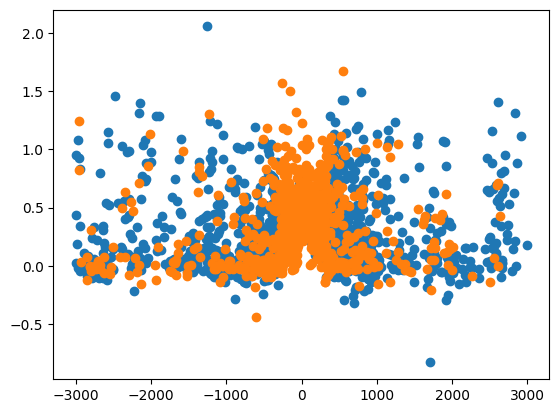

In [3]:
df = df.dropna()
X = df.dropna(subset = "prim_TSS_dist5p").loc[:, ["prim_TSS_dist5p"]]
y = df.dropna(subset = "prim_TSS_dist5p").loc[:, "score"]

# splitting training/test sets
perc_test = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = perc_test, random_state = 42)

def bin_and_average(df, bins):    
    df["X_bin"] = pd.cut(df["prim_TSS_dist5p"], bins = bins)
    
    bin_means = df.groupby("X_bin")["score"].mean().reset_index()
    bin_means["center"] = bin_means["X_bin"].apply(lambda row: row.left + (np.abs(row.left - row.right) / 2))
    
    return bin_means.dropna()

concat_df = pd.concat([X_train, y_train], axis = 1)
num_bins = 50000
binned_df = bin_and_average(concat_df, int((1 - perc_test) * num_bins))

binned_test_df = bin_and_average(pd.concat([X_test, y_test], axis = 1), int(perc_test * num_bins))

plt.scatter(binned_df["center"], binned_df["score"])
plt.scatter(binned_test_df["center"], binned_test_df["score"])

### Fitting model to SVR
Two statements are given - one is to fit to binned data, other is to fit to actual data. GridSearchCV is commented out because it takes a long time and seems to overfit to the existing data, but should probably be messed around with more in the future.

In [8]:
# fitting to binned data
# svr = svm.SVR(kernel = "rbf")
# parameters = {"C": Real(0.001, 100, prior = "log-uniform"),
#               "gamma":Real (1E-8, 1, prior = "log-uniform")}
# grid_svr = BayesSearchCV(svr, parameters, n_jobs = -1, scoring = "neg_mean_squared_error", iters = 50)
# grid_svr.fit(binned_df["center"].to_numpy().reshape(-1, 1), binned_df["score"].to_numpy().reshape(-1, 1))
# with open("models/binned_test_SVR.pk1", "wb") as file:
#     pickle.dump(grid_svr, file)
    
with open("models/binned_test_SVR.pk1", "rb") as file:
    grid_svr = pickle.load(file)
print(f"R^2: {grid_svr.score(binned_test_df['center'].to_numpy().reshape(-1, 1), binned_test_df['score'].to_numpy().reshape(-1, 1))}")

R^2: -0.0787502796751135


### Plotting fit
Plotted with binned values and actual values

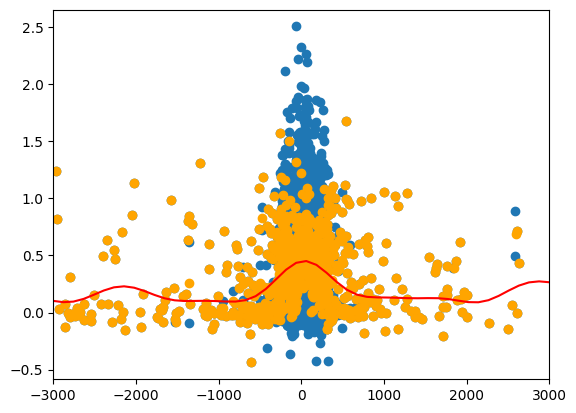

In [9]:
plot_X = np.linspace(-3000, 3000).reshape(-1, 1)
best_svr = grid_svr.best_estimator_
y_pred = best_svr.predict(plot_X)

plt.scatter(X_test, y_test)
plt.scatter(binned_test_df["center"], binned_test_df["score"], color = "orange")
plt.plot(plot_X, y_pred, color = "red")
plt.xlim(-3000, 3000)
plt.show()

### Adding linearized distance for all distances
Adding linearized values (obtained from SVM fit) for all four distance vectors. Plots for each for sanity.

c:\Users\jacks\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(
c:\Users\jacks\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


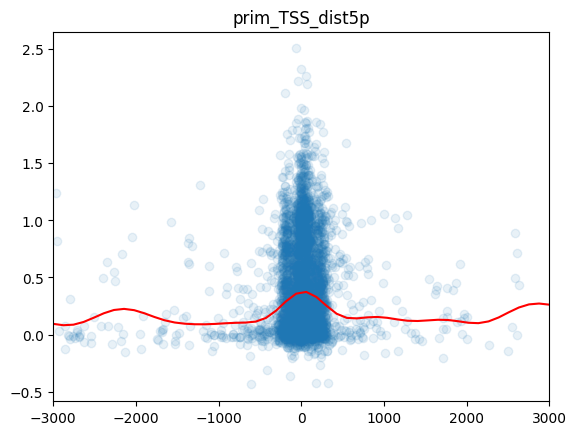

c:\Users\jacks\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(
c:\Users\jacks\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


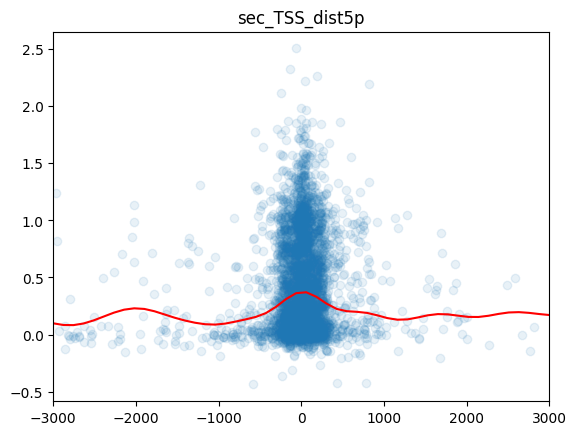

c:\Users\jacks\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(
c:\Users\jacks\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


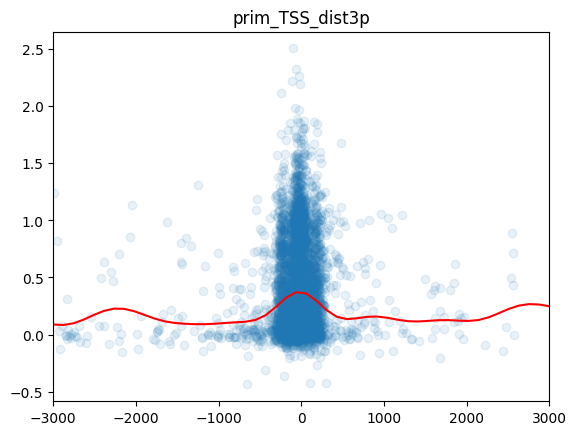

c:\Users\jacks\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(
c:\Users\jacks\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


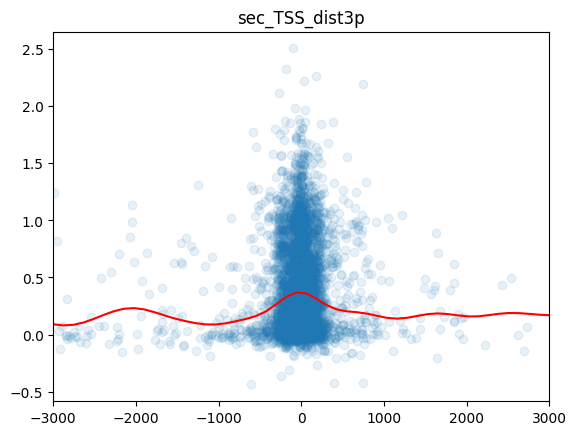

In [11]:
vars = ("prim_TSS_dist5p", "sec_TSS_dist5p", "prim_TSS_dist3p", "sec_TSS_dist3p")

for var in vars:
    # setting up X and y for variable
    X = df.dropna(subset = var).loc[:, [var]]
    y = df.dropna(subset = var).loc[:, "score"]
    
    # splitting training and testing sets based on value defined earlier
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = perc_test, random_state = 42)
    best_svr.fit(X_train, y_train)
    with open("models/" + var + "_test_SVR.pk1", "wb") as file:
        pickle.dump(best_svr, file)
    
    # with open("models/" + var + "_test_SVR.pk1", "rb") as file:
    #     best_svr = pickle.load(file)
    
    # update original dataframe with normalized values
    df[("norm_" + var)] = best_svr.predict(df[var].to_numpy().reshape(-1, 1))
    
    plot_X = np.linspace(-3000, 3000).reshape(-1, 1)
    y_pred = best_svr.predict(plot_X)

    plt.scatter(X_test, y_test, alpha = 0.1)
    plt.plot(plot_X, y_pred, color = "red")
    plt.xlim(-3000, 3000)
    plt.title(var)
    plt.show()

## Adding GC content

In [12]:
for base in ("A", "C", "T", "G"):
    df[("frac_" + base)] = df.apply(lambda row: row["sequence"].count(base) / row["length"], axis = 1)
    
df["GC_content"] = df["frac_C"] + df["frac_G"]

## One-hot encoding vectors for monomer bases at each position

In [13]:
max_len = df["sequence"].apply(len).agg(max)
bps = ["A", "C", "T", "G"]

def encode_monomer(seq, max_len):
    one_hot_vector = np.zeros((max_len, len(bps)))
    
    for i, bp in enumerate(seq):
        if bp in bps:
            one_hot_vector[i, bps.index(base)] = 1
    return one_hot_vector

encoded_monomers = df["sequence"].apply(lambda x: encode_monomer(x, max_len))

for i in range(max_len):
    for j, base in enumerate(bps):
        df[f"pos_{i+1}_{base}"] = encoded_monomers.apply(lambda x: x[i, j])

C:\Users\jacks\AppData\Local\Temp\ipykernel_9976\819772943.py:1: FutureWarning: The provided callable <built-in function max> is currently using Series.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  max_len = df["sequence"].apply(len).agg(max)
C:\Users\jacks\AppData\Local\Temp\ipykernel_9976\819772943.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"pos_{i+1}_{base}"] = encoded_monomers.apply(lambda x: x[i, j])
C:\Users\jacks\AppData\Local\Temp\ipykernel_9976\819772943.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once u

## One-hot encoding vectors for dimers at each position

In [14]:
combo_bps = []
for i, b1 in enumerate(bps):
    for j, b2 in enumerate(bps):
        combo_bps.append(b1 + b2)

def encode_dimer(seq, max_len):
    one_hot_vector = np.zeros((max_len, len(combo_bps)))
    
    # iterating over two bases at a time, in order
    for i in range(len(seq) - 1):
        dimer = seq[i] + seq[i + 1]
        if dimer in combo_bps:
            one_hot_vector[i, combo_bps.index(dimer)] = 1
    return one_hot_vector

encoded = df["sequence"].apply(lambda x: encode_dimer(x, max_len))

for i in range(max_len):
    for j, bases in enumerate(combo_bps):
        df[f"pos_{i+1}{i+2}_{bases}"] = encoded.apply(lambda x: x[i, j])

C:\Users\jacks\AppData\Local\Temp\ipykernel_9976\1892224224.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"pos_{i+1}{i+2}_{bases}"] = encoded.apply(lambda x: x[i, j])
C:\Users\jacks\AppData\Local\Temp\ipykernel_9976\1892224224.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"pos_{i+1}{i+2}_{bases}"] = encoded.apply(lambda x: x[i, j])
C:\Users\jacks\AppData\Local\Temp\ipykernel_9976\1892224224.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many 

## Running off-target analysis for each sgRNA

### Generating input.txt
Commented out for now because this takes ~2 hours to run on the current dataset

In [135]:
# # normalize all sgRNAs to have the same length as the max length sgRNA (by adding Ns in front)
# max_len = df["sequence"].apply(len).max()

# def normalize_str_len(str, max_len):
#     while len(str) < max_len:
#         str = "N" + str
#     return(str)

# df["sequence"] = df["sequence"].apply(normalize_str_len, args = (max_len,))

# # preparing input strings for cas-offinder
# pam = "NGG"
# full_pam = ("N" * max_len) + pam

# co_input = f"../genomes/human_hg19\n{full_pam} 2 1"
# for i, seq in enumerate(df["sequence"], start = 1):
#     co_input = co_input + f"\n{seq}NNN 3 Seq{i}"

# # write input string to input.txt for cas-offinder
# with open("input.txt", "w") as file:
#     file.write(co_input)

# # running subprocess for cas-offinder (WARNING: MAY TAKE A VERY LONG TIME TO RUN)
# subprocess.run(f".\cas-offinder input.txt G output.txt")

### Reading output.txt, adding MMs to dataframe
Currently going with the following approach:

- Count the number of off-targets with 1, 2, and 3 mismatches
- Sum them together for each sequence
- Add those three as three additional features

While this does treat all OTs as equal, which is not correct, ideally it should show some correlation between low numbers of off-target and higher scores, with less mismatches having higher impacts

In [ ]:
co_output = pd.read_csv("output.txt", sep = "\t", comment = "#", header = None)
co_output.columns = ["WT", "chromosome", "posn", "OT", "dir", "mismatches"]

# loop through each all numbers of mismatches and count how many each sequence has for each number
for MM in (1, 2, 3):
    df[f"{MM}_MMs"] = df["sequence"].apply(lambda seq: len(co_output.loc[(co_output["WT"].str.contains(seq)) &
                                                                         (co_output["mismatches"] == MM), :]))

# Organizing, scaling data for ML methods
All columns not relating to predicting score (INCLUDING non-normalized distance from TSS) are dropped in the creation of the training and test sets

In [15]:
X = df.drop(columns = ["score", 
                       "gene", 
                       "chromosome",
                       "PAM_coord",
                       "strand targeted", 
                       "sequence", 
                       "transcript", 
                       "strand", 
                       "TSS source",
                       "prim_TSS_5p",
                       "prim_TSS_3p",
                       "sec_TSS_5p",
                       "sec_TSS_3p",
                       "prim_TSS_dist5p",
                       "prim_TSS_dist3p",
                       "sec_TSS_dist5p",
                       "sec_TSS_dist3p"])
y = df.loc[:, "score"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

# Random Forest Regression
Gilbert and his lab used elastic net linear regression - I tried this, but it just wasn't working.

## Fitting model

In [50]:
from sklearn.ensemble import RandomForestRegressor

rf_reg = RandomForestRegressor()

params = {
    "n_estimators": Integer(1, 500),
    "max_depth": Integer(1, 100)
}
grid_rf_reg = BayesSearchCV(rf_reg, params, scoring = "neg_mean_squared_error", n_iter = 30, n_jobs = -1, cv = 5)
_ = grid_rf_reg.fit(X_train, y_train)
with open("models/RF.pk1", "wb") as file:
        pickle.dump(grid_rf_reg, file)

# with open("models/RF.pk1", "rb") as file:
#     grid_rf_reg = pickle.load(file)

KeyboardInterrupt: 

In [129]:
print(grid_rf_reg.best_params_)

RandomForestRegressor(max_depth=87, n_estimators=426)


## Comparing model fit with test set

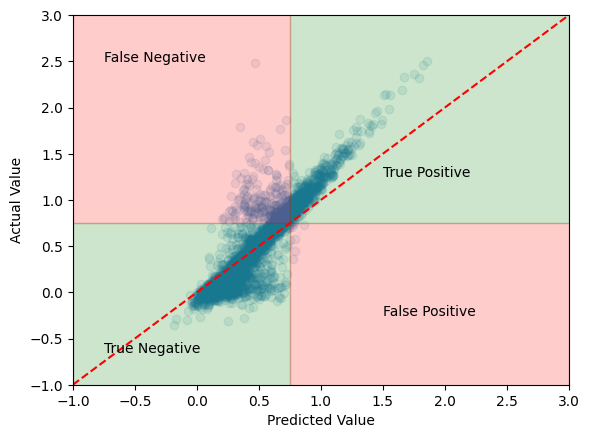

In [144]:
best_rf_reg = grid_rf_reg.best_estimator_
pred_score = best_rf_reg.predict(X)
y_pred = best_rf_reg.predict(X_test)

threshold = 0.75 # threshold by where we consider an sgRNA to be "highly active"
xmin = -1 # minimum on x axis
xmax = 3 # maximum on x axis

# fitting a linear regression to the data
lin_reg = LinearRegression()
lin_reg.fit(y_pred, y_test)
slope = lin_reg.coef_[0] # perfect fit, slope = 1
intercept = lin_reg.coef[1] # perfect fit, intercept = 0

x = np.linspace(xmin, xmax, 100)
xdist = (threshold - xmin) / (xmax - xmin) # distance along the x axis to place the location of threshold
plt.scatter(y_pred, y_test, alpha = 0.1)
plt.plot(x, x, color = 'red', linestyle = '--', label = 'Identity Line (y=x)')
plt.plot(x, lin_reg.predict(x), color = "black") # plotting linear regression
plt.xlabel("Predicted Value")
plt.ylabel("Actual Value")
plt.axhspan(-5, threshold, color = "green", alpha = 0.2, xmax = xdist) # true negative
plt.axhspan(threshold, 5, color = "green", alpha = 0.2, xmin = xdist) # true positive
plt.axhspan(-5, threshold, color = "red", alpha = 0.2, xmin = xdist) # false positive
plt.axhspan(threshold, 5, color = "red", alpha = 0.2, xmax = xdist) # false negative
plt.text(1.5, 1.25, "True Positive")
plt.text(-0.75, -0.65, "True Negative")
plt.text(1.5, -0.25, "False Positive")
plt.text(-0.75, 2.5, "False Negative")
plt.xlim([xmin, xmax])
plt.ylim([xmin, xmax])
plt.show()

## ROC curve (and other metrics)

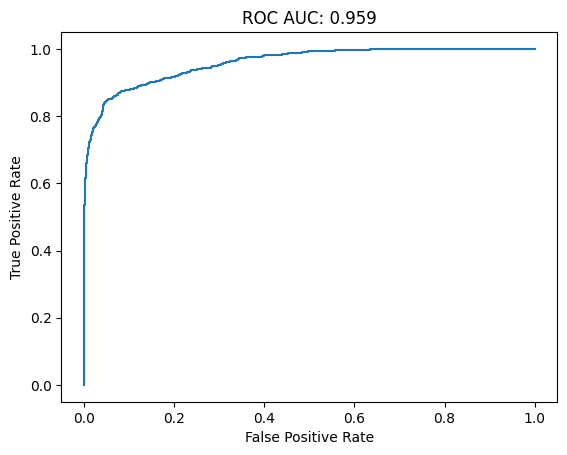

In [147]:
actual_pos = df["score"] >= threshold
y_prob = y_test >= threshold

# ROC curve
fpr, tpr, thresholds = roc_curve(y_prob, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.title("ROC AUC: " + str(round(roc_auc, 3)))
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

# precision-recall curve
precision, recall, threshholds = precision_recall_curve(y_prob, y_pred)
roc_pr = auc(recall, precision)

plt.figure()
plt.title("PR AUC: " + str(round(roc_pr, 3)))
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()

# f1 score
f1 = f1_score(y_prob, y_pred >= threshold)
print("F1 score: ", f1)

# Gradient Boosting Regression
Allegedly more robust than random forest regression.

## Fitting model

In [17]:
from lightgbm import LGBMRegressor

# lgbm_reg = LGBMRegressor(reg_lambda = 1)
# params = {
#     "n_estimators": Integer(250, 750),
#     "learning_rate": Real(0.001, 1, prior = "log-uniform"),
#     "num_leaves": Integer(2, 1000, prior = "log-uniform")
# }
# grid_lgbm_reg = BayesSearchCV(lgbm_reg, params, scoring = "r2", n_iter = 30, n_jobs = -1, cv = 5)
# _ = grid_lgbm_reg.fit(X_train, y_train)
# with open("models/LGBM.pk1", "wb") as file:
#         pickle.dump(grid_lgbm_reg, file)
    
with open("models/RF.pk1", "rb") as file:
    grid_rf_reg = pickle.load(file)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000629 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2139
[LightGBM] [Info] Number of data points in the train set: 14567, number of used features: 365
[LightGBM] [Info] Start training from score 0.425392


## Comparing model fit with test set

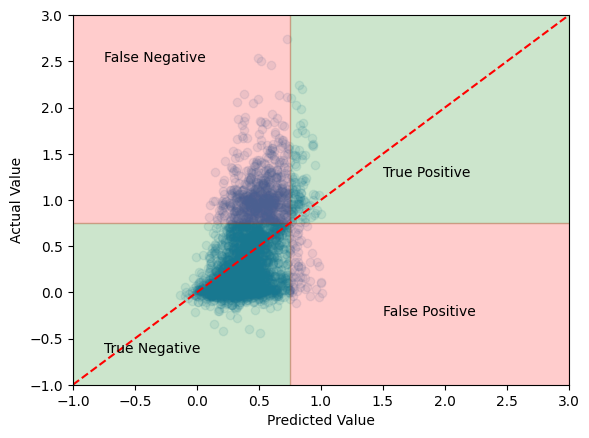

In [49]:
best_lgbm_reg = grid_lgbm_reg.best_estimator_
pred_score = best_lgbm_reg.predict(X)
y_pred = best_lgbm_reg.predict(X_test)

threshold = 0.75 # threshold by where we consider an sgRNA to be "highly active"
xmin = -1 # minimum on x axis
xmax = 3 # maximum on x axis

x = np.linspace(xmin, xmax, 100)
xdist = (threshold - xmin) / (xmax - xmin) # distance along the x axis to place the location of threshold
plt.scatter(y_pred, y_test, alpha = 0.1)
plt.plot(x, x, color = 'red', linestyle = '--', label = 'Identity Line (y=x)')
plt.xlabel("Predicted Value")
plt.ylabel("Actual Value")
plt.axhspan(-5, threshold, color = "green", alpha = 0.2, xmax = xdist) # true negative
plt.axhspan(threshold, 5, color = "green", alpha = 0.2, xmin = xdist) # true positive
plt.axhspan(-5, threshold, color = "red", alpha = 0.2, xmin = xdist) # false positive
plt.axhspan(threshold, 5, color = "red", alpha = 0.2, xmax = xdist) # false negative
plt.text(1.5, 1.25, "True Positive")
plt.text(-0.75, -0.65, "True Negative")
plt.text(1.5, -0.25, "False Positive")
plt.text(-0.75, 2.5, "False Negative")
plt.xlim([xmin, xmax])
plt.ylim([xmin, xmax])
plt.show()

## ROC (and other metrics)

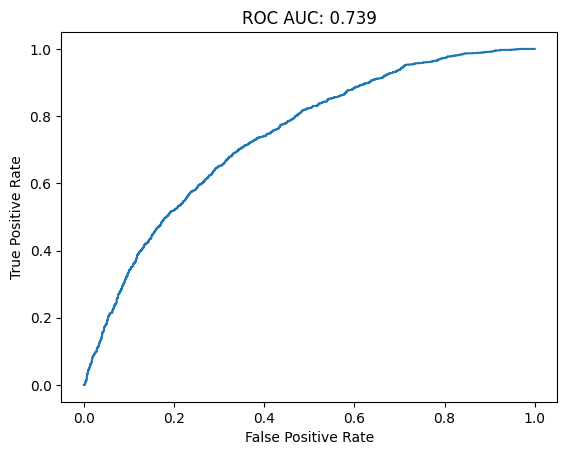

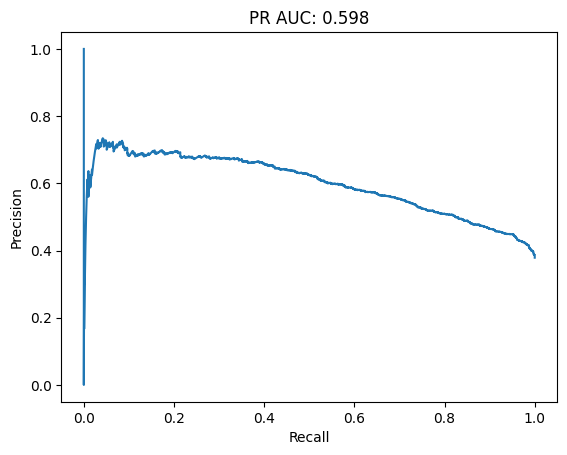

F1 score:  0.5639625585023401


In [48]:
actual_pos = df["score"] >= threshold
y_prob = y_test >= threshold

# ROC curve
fpr, tpr, thresholds = roc_curve(y_prob, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.title("ROC AUC: " + str(round(roc_auc, 3)))
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

# precision-recall curve
precision, recall, threshholds = precision_recall_curve(y_prob, y_pred)
roc_pr = auc(recall, precision)

plt.figure()
plt.title("PR AUC: " + str(round(roc_pr, 3)))
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()

# f1 score
f1 = f1_score(y_prob, y_pred >= threshold)
print("F1 score: ", f1)